In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model

In [2]:
%matplotlib inline

In [3]:
summary = pd.read_csv("atussum_2013.dat")
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11385 entries, 0 to 11384
Columns: 413 entries, tucaseid to t500107
dtypes: float64(1), int64(412)
memory usage: 36.0 MB


In [4]:
def activity_by_age(df, activity_code, subsample=True):
    activity_col = "t{}".format(activity_code)
    df = df[['TUFINLWGT', 'TEAGE', activity_col]]
    df = df.rename(columns={"TUFINLWGT": "weight", "TEAGE": "age", activity_col: "minutes"})
    if subsample:
        df = df[df.age % 5 == 0]
    df['weighted_minutes'] = df.weight * df.minutes
    df = df.groupby("age").sum()
    df['mean_minutes'] = df.weighted_minutes / df.weight
    df = df[['mean_minutes']]
    return df

Lets get a ```dataFrame``` from our ```summary``` containing "Medical Care" data.

The code for Medical Care is 080401.

Also do a scatter plot with the ```medical_care.index``` as the x, and the medical_care.mean_minutes as the y.

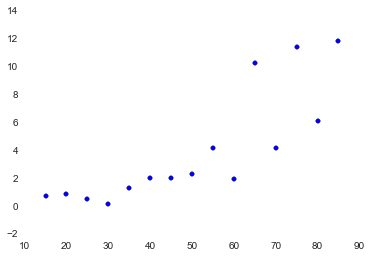

In [77]:
medical_care = activity_by_age(summary, "080401")
plt.scatter(medical_care.index, medical_care.mean_minutes)
plt.show()

#Linear Regression
Linear regression is a way of modeling a relationship between two features in a way that given 2 variables, 1 known, and 1 unknown we can give a close approximation of what our unknown value may equate to.

Or as wikipedia says:
> In linear regression, data are modeled using linear predictor functions, and unknown model parameters are estimated from the data 

Without getting too in depth with how to calculate the predictor function (our line) our goal is going to be to get the minimum (closest to the mean) of our data along an axis.  If our prediction is too aggressive (steep) we will not get an accurate function.  If our prediction is too conservative (shallow) we will also not get an accurate function.  You ultimately want your line to visibly bisect your distribution of data.

The function below will apply a regression function across a dataframe and square the differences in each cell from the mean. Finally it will divide the sum of differences by 2 times the amount of differences we find.

In [8]:
def linear_least_squares(df, fn):
    values = df.index.map(fn)
    diffs = df.mean_minutes - values
    diffs_squared = diffs ** 2
    return diffs_squared.sum() / (2 * len(diffs)) 

In order to use our `linear_least_squares` function we need to pass it a function.  This function will act as our "line prediction" in which we are attempting to correctly bisect our data.

This is the code to plot a line with a slope of `1/4`:
>`lambda x: 0 + 0.25 * x`

Pass the `medical_care` frame to the `linear_least_squares` along with the function above and print your findings.

Also create a scatter plot of your data as well as your regression line prediction.

[  3.75   5.     6.25   7.5    8.75  10.    11.25  12.5   13.75  15.    16.25
  17.5   18.75  20.    21.25]
40.5573618265


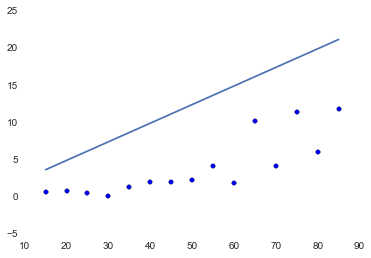

In [78]:
fn1 = lambda x: 0.25 * x + 0
print(linear_least_squares(medical_care, fn1))

plt.scatter(medical_care.index, medical_care.mean_minutes)
plt.plot(medical_care.index, fn1(medical_care.index))

Try the same but this time with the following linear function:

>`lambda x: 0 + 0.15 * x`

Overlay your original line with an alpha of `0.3`

In [11]:
fn2 = lambda x: 0.15 * x + 0

In [12]:
print(linear_least_squares(medical_care, fn2))

8.41239858335


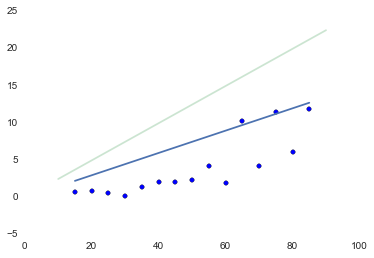

In [15]:
plt.scatter(medical_care.index, medical_care.mean_minutes)
plt.plot(medical_care.index, fn2(medical_care.index))
xmin, xmax = plt.xlim()
xs = np.linspace(xmin, xmax, 100)
plt.plot(xs, fn1(xs), alpha=0.3)

3.46491696178
8.41239858335
40.5573618265


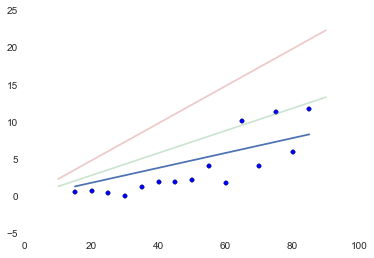

In [18]:
fn3 = lambda x: 0 + 0.1 * x
print(linear_least_squares(medical_care, fn3))
print(linear_least_squares(medical_care, fn2))
print(linear_least_squares(medical_care, fn1))

plt.scatter(medical_care.index, medical_care.mean_minutes)
plt.plot(medical_care.index, fn3(medical_care.index))
plt.plot(xs, fn2(xs), alpha=0.3)
plt.plot(xs, fn1(xs), alpha=0.3)

57.8416571421
3.46491696178
8.41239858335


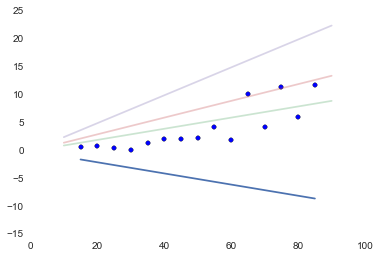

In [19]:
fn4 = lambda x: 0 + -0.1 * x
print(linear_least_squares(medical_care, fn4))

print(linear_least_squares(medical_care, fn3))
print(linear_least_squares(medical_care, fn2))

plt.scatter(medical_care.index, medical_care.mean_minutes)
plt.plot(medical_care.index, fn4(medical_care.index))
plt.plot(xs, fn3(xs), alpha=0.3)

plt.plot(xs, fn2(xs), alpha=0.3)
plt.plot(xs, fn1(xs), alpha=0.3)

This is awesome!  However, this is also not practical to do by hand every time.  Imagine this but with 1000 dimensions.  Forget about it!

Time to use scikit-learn to do this for us.  We will be using ```LinearRegression()``` model and calling it's ```fit``` method with our data.

In [20]:
regression = linear_model.LinearRegression()

In [21]:
regression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

```scikit-learn``` expects the data in a certain way which is array[sample][feature].  Our data is currently opposite of the so we need to fix it

In [39]:
transposed_index = np.array(medical_care.index.values).reshape((-1, 1))
transposed_index

array([[15],
       [20],
       [25],
       [30],
       [35],
       [40],
       [45],
       [50],
       [55],
       [60],
       [65],
       [70],
       [75],
       [80],
       [85]])

In [42]:
medical_care.mean_minutes.values

array([  0.79017668,   0.89924901,   0.59729932,   0.21247888,
         1.37000971,   2.09209226,   2.09961959,   2.3645808 ,
         4.25203874,   2.01804124,  10.30103765,   4.24476389,
        11.4600384 ,   6.15095593,  11.87694356])

In [43]:
regression.fit(transposed_index, medical_care.mean_minutes.values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Now that we have fit our prediction model to our data lets do cool stuff to it.

In [48]:
regression.predict(60)

array([[ 5.53689204]])

In [49]:
print(regression.coef_, regression.intercept_)

[[ 0.14882703]] [-3.39272994]


In [50]:
regression.score(np.array(medical_care.index.values).reshape((-1, 1)), 
               medical_care.mean_minutes.values)

0.67786204814148743

[ 2.4560715]


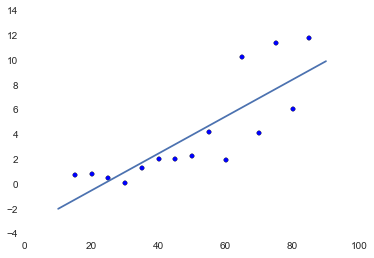

In [51]:
fn = lambda x: regression.predict(x)[0]
print(linear_least_squares(medical_care, fn))
plt.scatter(medical_care.index, medical_care.mean_minutes)
xmin, xmax = plt.xlim()
xs = np.linspace(xmin, xmax, 100)
plt.plot(xs, [fn(x) for x in xs])

In [54]:
print(linear_least_squares(medical_care, fn4))
print(linear_least_squares(medical_care, fn3))
print(linear_least_squares(medical_care, fn2))
print(linear_least_squares(medical_care, fn1))
print(linear_least_squares(medical_care, fn))

57.8416571421
3.46491696178
8.41239858335
40.5573618265
2.45607150302


In [76]:
medical_care.values

array([[  0.79017668],
       [  0.89924901],
       [  0.59729932],
       [  0.21247888],
       [  1.37000971],
       [  2.09209226],
       [  2.09961959],
       [  2.3645808 ],
       [  4.25203874],
       [  2.01804124],
       [ 10.30103765],
       [  4.24476389],
       [ 11.4600384 ],
       [  6.15095593],
       [ 11.87694356]])